In [17]:
import numpy as np

npzfile = np.load('./CBCL.npz')
trainface = npzfile['arr_0']
trainnonface = npzfile['arr_1']
testface = npzfile['arr_2']
testnonface = npzfile['arr_3']

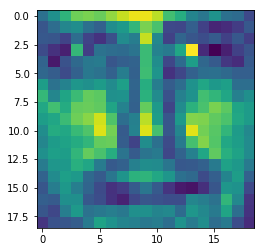

In [6]:
%matplotlib inline
from PIL import Image
from matplotlib.pyplot import imshow 
I = Image.fromarray(trainface[0, :].reshape((19, 19)))
imshow(I)
# pop out window
# I .show()

In [10]:
from io import BytesIO
from IPython.display import display
from IPython.display import Image as img

def display_img_array(ima):
    ima = ima.convert('RGB')
    bio = BytesIO()
    ima.save(bio, format='png')
    display(img(bio.getvalue(), format='png'))
    
display_img_array(I)

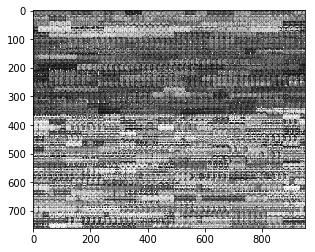

In [15]:
# 印50張
raw = np.zeros((40*19, 50*19))
for y in range(40):
    for x in range(50):
        I1 = trainface[y*50+x, :].reshape((19, 19))
        raw[y*19:y*19+19, x*19:x*19+19] = I1
        
imshow(raw, cmap ='gray')

In [28]:
import random

def BPNNtrain(pf, nf, hn, lr, iter):
    pn = pf.shape[0]
    nn = nf.shape[0]
    fn = pf.shape[1]
    feature = np.append(pf, nf, axis=0)
    target = np.append(np.ones((pn, 1)), np.zeros((nn, 1)), axis=0)
    WI = np.random.normal(0, 1, (fn+1, hn))
    WO = np.random.normal(0, 1, (hn+1, 1))
    for t in range(iter):
        s = random.sample(range(pn+nn), pn+nn)
        for i in range(pn+nn):
            # input signal
            ins = np.append(feature[s[i], :], 1)
            oh = ins.dot(WI)
            # sigmoid
            oh = 1/ (1 + np.exp(-oh))
            hs = np.append(oh, 1)
            out = hs.dot(WO)
            out = 1/ (1 + np.exp(-out))
            dk = out*(1-out)*(target[s[i]] - out)
            dh = oh*(1-oh)*WO[:hn, 0]*dk
            WO[:, 0] += lr*dk*hs
            for j in range(hn):
                WI[:, j] += lr*dh[j]*ins
                
    model = dict()
    model['WI'] = WI
    model['WO'] = WO
    return model

network = BPNNtrain(trainface/ 255, trainnonface/255, 20, 0.01, 10)

def BPNNtest(feature, model):
    sn = feature.shape[0]
    WI = model['WI']
    WO = model['WO']
    hn = WI.shape[1]
    out = np.zeros((sn, 1))
    for i in range(sn):
        ins = np.append(feature[i, :], 1)
        oh = ins.dot(WI)
        # sigmoid
        oh = 1/ (1 + np.exp(-oh))
        hs = np.append(oh, 1)
        out[i] = hs.dot(WO)
        out[i] = 1/ (1 + np.exp(-out[i]))
    return out
        
pscore = BPNNtest(trainface/ 255, network)
nscore = BPNNtest(trainnonface/ 255, network)

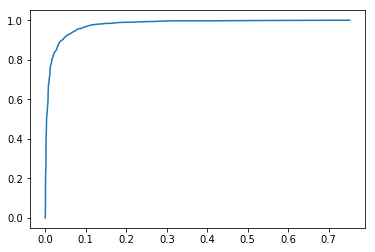

In [29]:
import matplotlib.pyplot as plt
X = np.zeros(99)
Y = np.zeros(99)

for i in range(99):
    threshold = (i+1)/ 100
    X[i] = np.mean(nscore > threshold)
    Y[i] = np.mean(pscore > threshold)
    
plt.plot(X, Y)
plt.show()